Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# SURE-Based Robust MRI Reconstruction with Diffusion Models (SMRD)
## Setup environment

In [ ]:
!pip install -r ./requirements.txt
%matplotlib inline

## Download demo data and checkpoint
We will download the demo data and checkpoint for the model. Note that the model is trained without taking into consideration of the sparse measurements. In our demo, we will condition the model on the sparse measurements to demonstrate usage of SURE-loss and Conjugate Gradient in the context of Diffusion-based MRI sparse-to-dense reconstruction.

The checkpoint is around 1.4GB, and the demo data is around 20MB.

In [2]:
# tell if checkpoints/mri-unet-smrd.pth exists or not, if not download it
!ls checkpoints/mri-unet-smrd.pth || (mkdir checkpoints && gdown -O checkpoints/mri-unet-smrd.pth 1NdkK4PDY1PVw4GgNAocYBuZ4_7yCo_hf)
# tell if demo_data.pkl.gz exists or not, if not download it
!ls demo_data.pkl.gz || gdown -O demo_data.pkl.gz 1k35KdU2EqnxndV9_7QPw04UhTlxSovNC

checkpoints/mri-unet-smrd.pth
demo_data.pkl.gz


## Setup imports

In [3]:
import os
import argparse
import numpy as np
import torch
import torch.fft as torch_fft

from tqdm import tqdm

from monai.config import print_config
from monai.networks.layers.conjugate_gradient import ConjugateGradient
from monai.losses.sure_loss import SURELoss, complex_diff_abs_loss

from models.ema import EMAHelper
from models.models import UNet
from mutils import (
    normalize,
    unnormalize,
    scale,
    get_sigmas,
    dict2namespace,
    get_mvue,
    update_pbar_desc,
    MulticoilForwardMRI,
)

from omegaconf import OmegaConf
import pickle
import gzip
import matplotlib.pyplot as plt

print_config()

MONAI version: 0+untagged.2961.g9755aa5
Numpy version: 1.24.4
Pytorch version: 2.1.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9755aa580ab152f3fa1d6c59c6123c061dfe7670
MONAI __file__: /home/<username>/anaconda3/envs/monai-py38/lib/python3.8/site-packages/monai-0+untagged.2961.g9755aa5-py3.8.egg/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.2.0
Tensorboard version: 2.14.0
gdown version: 4.6.3
TorchVision version: 0.16.2+cu121
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.37.1
mlflow version: 2.10.0
pynrrd version: 1.0.0
clearml version: 1.14.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Define the denoise and conjugate gradient step as one function

In [4]:
def denoise_cg_step(
    x,
    score,
    labels,
    step_size,
    noise,
    lambda_t,
    y_cond,
    cg_solve_fn: ConjugateGradient,
):
    # denoise step
    with torch.no_grad():
        p_grad = score(x, labels)
    y = x + step_size * (p_grad) + noise
    # CG step
    cg_in = torch.view_as_complex((y_cond + lambda_t.clone() * y).permute(0, 2, 3, 1))
    # solving eq.9 in the paper, using CG. with x0 = y_cond, y = y_cond + lambda_t * y.
    # during the CG steps, the update step will 'drag' the solution away from
    # y_cond, and towards y, based on the lambda_t value.
    y = cg_solve_fn(
        torch.view_as_complex(y_cond.permute(0, 2, 3, 1)),
        cg_in,)
    y = torch.view_as_real(y).permute(0, -1, 1, 2)
    return y

## Define the SMRD optimizer 
We will use it for the reconstruction from sparse MRI scans. The optimizer includes the sampling process that generates the dense MRI reconstruction condioned on sparse meausrements.

The core components of the optimizer are the SURE-based loss and the Conjugate Gradient step.
With the Conjugate Gradient step, we can enforce the generated dense MRI to be consistent with the sparse measurements;
With the SURE-based loss, we can decide when to stop the generation of the dense MRI, to avoid artifacts due to excessive sampling iterations.

In [5]:
class SMRDOptimizer(torch.nn.Module):
    def __init__(self, config, project_dir='./'):
        super().__init__()
        self.config = config
        self.SMRD_config = self._dict2namespace(config['langevin_config'])
        self.device = config['device']
        self.SMRD_config.device = config['device']
        self.project_dir = project_dir
        self.score = UNet(self.SMRD_config).to(self.device)
        self.sigmas_torch = get_sigmas(self.SMRD_config)
        self.sigmas = self.sigmas_torch.cpu().numpy()
        self.score = torch.nn.DataParallel(self.score)
        states = torch.load(os.path.join(project_dir, config['gen_ckpt']))
        self.score.load_state_dict(states[0], strict=True)
        if self.SMRD_config.model.ema:
            ema_helper = EMAHelper(mu=self.SMRD_config.model.ema_rate)
            ema_helper.register(self.score)
            ema_helper.load_state_dict(states[-1])
            ema_helper.ema(self.score)
        del states
        self.index = 0

    def _dict2namespace(self, config):
        namespace = argparse.Namespace()
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
        return namespace

    def _initialize(self):
        self.gen_outs = []

    def _ifft(self, x):
        x = torch_fft.ifftshift(x, dim=(-2, -1))
        x = torch_fft.ifft2(x, dim=(-2, -1), norm='ortho')
        x = torch_fft.fftshift(x, dim=(-2, -1))
        return x

    def _fft(self, x):
        x = torch_fft.fftshift(x, dim=(-2, -1))
        x = torch_fft.fft2(x, dim=(-2, -1), norm='ortho')
        x = torch_fft.ifftshift(x, dim=(-2, -1))
        return x

    def _sample(self, y):
        ref, mvue, maps, batch_mri_mask = y
        estimated_mvue = torch.tensor(get_mvue(ref.cpu().numpy(), maps.cpu().numpy()), device=ref.device)

        pbar = tqdm(range(self.config['start_iter'] + 1, self.SMRD_config.model.num_classes),
                    disable=(self.config['device'] != 0))
        pbar_labels = ['step_size', 'error', 'mean', 'max']
        step_lr = self.SMRD_config.sampling.step_lr

        def forward_operator(x): return MulticoilForwardMRI(
            self.config['orientation'])(torch.complex(x[:, 0], x[:, 1]), maps, batch_mri_mask)

        def inverse_operator(x): return torch.view_as_real(
            torch.sum(self._ifft(x) * torch.conj(maps), axis=1)).permute(0, 3, 1, 2)
        samples = torch.rand(
            y[0].shape[0],
            self.SMRD_config.data.channels,
            self.config['image_size'][0],
            self.config['image_size'][1],
            device=self.device,
        )
        n_steps_each = 3
        window_size = self.config['window_size'] * n_steps_each
        gt_losses = []
        lambdas = []
        sures = []

        lamda_init = self.config.lambda_init
        lamda_end = self.config.lambda_end
        if self.config.lambda_func == 'cnst':
            lamdas = lamda_init * torch.ones(len(self.sigmas), device=samples.device)
        elif self.config.lambda_func == 'linear':
            lamdas = torch.linspace(lamda_init, lamda_end, len(self.sigmas))
        elif self.config.lambda_func == 'learnable':
            with torch.enable_grad():
                init = torch.tensor(lamda_init, dtype=torch.float32)
                lamda = torch.nn.Parameter(init, requires_grad=True)
            lambda_lr = self.config['lambda_lr']
            optimizer = torch.optim.Adam([lamda], lr=lambda_lr)

        with torch.no_grad():
            for c in pbar:
                if c <= 1800:
                    n_steps_each = 3
                else:
                    n_steps_each = self.SMRD_config.sampling.n_steps_each
                sigma = self.sigmas[c]
                labels = torch.ones(samples.shape[0], device=samples.device) * c
                labels = labels.long()
                step_size = step_lr * (sigma / self.sigmas[-1]) ** 2

                for _ in range(n_steps_each):
                    with torch.enable_grad():
                        if self.config.lambda_func == 'learnable':
                            optimizer.zero_grad()
                        samples = samples.to('cuda')
                        if self.config.lambda_func == 'learnable':
                            samples = samples.requires_grad_(True)
                        noise = torch.randn_like(samples) * np.sqrt(step_size * 2)
                        # get score from model
                        with torch.no_grad():
                            p_grad = self.score(samples, labels)
                        estimated_mvue = estimated_mvue.clone().to('cuda')

                        if self.config.lambda_func == 'learnable':
                            samples = samples.requires_grad_(True)

                        torch.autograd.set_detect_anomaly(True)
                        if self.config.lambda_func == 'learnable':
                            pass
                        else:
                            lamda = lamdas[c]

                        if lamda.detach().cpu().numpy() > 0:
                            lamda_applied = lamda.clone()
                        else:
                            # If learning results in a negative lamda, apply initial lamda
                            lamda_applied = torch.tensor(lamda_init, dtype=torch.float32)

                        # define the linear operator, in this case a 2D IFFT
                        def model_normal(m, estimated_mvue=estimated_mvue, lamda_applied=lamda_applied):
                            out = normalize(torch.view_as_real(m).permute(0, -1, 1, 2), estimated_mvue)
                            out = forward_operator(out)
                            out = inverse_operator(out)
                            out = unnormalize(out, estimated_mvue)
                            out = out + lamda_applied.clone() * torch.view_as_real(m).permute(0, -1, 1, 2)
                            out = torch.view_as_complex(out.permute(0, 2, 3, 1))
                            return out

                        cg_solve = ConjugateGradient(model_normal, self.config['num_cg_iter'])
                        samples.size(0)
                        meas = forward_operator(samples)  # H x hat t, ref = y
                        zf = inverse_operator(ref)
                        zf = unnormalize(zf, estimated_mvue)
                        zf = zf.type(torch.float32)
                        samples_input = samples
                        samples = samples.to(self.device)

                        # REVERSE DIFFUSION (aka denoise) #
                        # Line 3 in Algo.1 in the paper
                        samples = samples + step_size * (p_grad) + noise
                        #

                        # Line 4
                        cg_in = torch.view_as_complex((zf + lamda_applied.clone() * samples).permute(0, 2, 3, 1))
                        samples = cg_solve(torch.view_as_complex(zf.permute(0, 2, 3, 1)), cg_in)
                        #

                        samples = torch.view_as_real(samples).permute(0, -1, 1, 2).type(torch.FloatTensor)
                        if self.config.lambda_func == 'learnable':
                            samples = samples.requires_grad_(True)
                        samples = samples.to(self.device)

                        # compute metrics
                        metrics = [step_size, (meas - ref).norm(), (p_grad).abs().mean(), (p_grad).abs().max()]
                        update_pbar_desc(pbar, metrics, pbar_labels)

                        # create perturbed input for monte-carlo SURE
                        # Line 5-6--
                        sureloss = SURELoss(
                            perturb_noise=torch.randn_like(samples),
                            eps=torch.abs(zf.max()) / 1000,)

                        # operator is a partial function of denoise_cg_step
                        cg_lambda = lamda_applied.clone()

                        def denoise_cg_operator(
                                x,
                                score=self.score,
                                labels=labels,
                                step_size=step_size,
                                noise=noise,
                                lambda_t=cg_lambda,
                                zf=zf,
                                cg_solve=cg_solve,):
                            return denoise_cg_step(
                                x,
                                score=score,
                                labels=labels,
                                step_size=step_size,
                                noise=noise,
                                lambda_t=lambda_t,
                                y_cond=zf,
                                cg_solve_fn=cg_solve,)

                        # apply the SURE loss function
                        sure_loss = sureloss(
                            operator=denoise_cg_operator,
                            x=samples_input,
                            y_pseudo_gt=zf,
                            y_ref=samples,
                            complex_input=True,
                        )
                        # --Line 5-6

                        sures.append(sure_loss.detach().cpu().numpy())
                        gt_l2_loss = complex_diff_abs_loss(samples, mvue.squeeze(1))
                        gt_losses.append(gt_l2_loss.detach().cpu().numpy())
                        lambdas.append(lamda.clone().detach().cpu().numpy())

                        init_lambda_update = self.config['init_lambda_update']
                        last_lambda_update = self.config['last_lambda_update']
                        if c > init_lambda_update:
                            if c < last_lambda_update:
                                if self.config.lambda_func == 'learnable':
                                    # we will use SURE loss to update lambda
                                    loss = sure_loss
                                    loss.backward(retain_graph=True)
                                    optimizer.step()

                        if self.config.lambda_func == 'learnable':
                            samples = samples.detach()
                            lamda = lamda.detach()
                            zf = zf.detach()
                            loss = loss.detach()

                    if self.config.early_stop == 'stop':
                        # EARLY STOPPING USING SURE LOSS
                        # check the self-validation loss for early stopping
                        if len(sures) > 3 * window_size:
                            if c > 3 * window_size:
                                if np.mean(sures[-window_size:]) > np.mean(sures[-2 * window_size:-window_size]):
                                    print('\nAutomatic early stopping activated.')
                                    return normalize(samples, estimated_mvue)
                    else:
                        pass

                    if np.isnan((meas - ref).norm().cpu().numpy()):
                        return normalize(samples, estimated_mvue)

                # show images during the generation process to see how the reconstruction evolves
                if (c) % self.config['save_iter'] == 0 :
                    estimated_mvue = estimated_mvue.cpu()
                    img_gen = normalize(samples, estimated_mvue)
                    outputs = normalize(samples, estimated_mvue)
                    outputs = outputs.permute(0, 2, 3, 1)
                    outputs = outputs.contiguous()
                    outputs = torch.view_as_complex(outputs)
                    to_display = torch.view_as_complex(img_gen.permute(
                        0, 2, 3, 1).reshape(-1, self.config['image_size'][0],
                                            self.config['image_size'][1], 2
                                            ).contiguous()).abs()
                    if self.config['anatomy'] == 'brain':
                        # flip vertically
                        to_display = to_display.flip(-2)
                    elif self.config['anatomy'] == 'stanford_knees':
                        # do nothing
                        pass
                    else:
                        pass

                    to_display = scale(to_display)
                    plt.figure()
                    plt.imshow(to_display[0].cpu().numpy(), cmap='gray')
                    plt.title(f'Reconstruction at step {c-self.config["start_iter"]}')
                    plt.show()

        samples = samples.detach()
        return normalize(samples, estimated_mvue)

    def sample(self, y):
        self._initialize()
        mvue = self._sample(y)
        outputs = []
        for i in range(y[0].shape[0]):
            outputs_ = {
                'mvue': mvue[i:i + 1],
            }
            outputs.append(outputs_)
        return outputs

Load configuration, checkpoint and data. We will also initiate and configure the SMRD optimizer and does the sampling process.

In [6]:
# load config file
config = OmegaConf.load('configs/demo/SMRD-brain_T2-noise005-R8.yaml')
# get current working directory
project_dir = './'
# setup
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
project_name = config['anatomy']
rank = 0
# pretty(config)
config['device'] = rank
sampler = None
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
SMRD_optimizer = SMRDOptimizer(config, project_dir)
SMRD_optimizer.to(rank)

# load data
with gzip.open('demo_data.pkl.gz', 'rb') as f:
    sample = pickle.load(f)

'''
ref: one complex image per coil
mvue: one complex image reconstructed using the coil images and the sensitivity maps
maps: sensitivity maps for each one of the coils
mask: binary valued kspace mask
'''
ref, mvue, maps, mask = sample['ground_truth'], sample['mvue'], sample['maps'], sample['mask']
mvue, maps, mask = torch.from_numpy(mvue), torch.from_numpy(maps), torch.from_numpy(mask)  # from numpy to torch
ref, mvue, maps, mask = ref.unsqueeze(0), mvue.unsqueeze(0), maps.unsqueeze(0), mask.unsqueeze(0)  # add batch dimension

# move everything to cuda
ref = ref.to(rank).type(torch.complex128)
mask = mask.to(rank)
noise_std = config['noise_std']
noise = mask[None, :, :] * \
    torch.view_as_complex(torch.randn(ref.shape + (2,)).to(rank)) * noise_std * torch.abs(ref).max()

ref = ref + noise.to(rank)
mvue = mvue.to(rank)
maps = maps.to(rank)

estimated_mvue = torch.tensor(
    get_mvue(ref.cpu().numpy(),
             maps.cpu().numpy()),
    device=ref.device,
)

exp_names = []

batch_idx = 0
exp_name = 'demo'
exp_names.append(exp_name)
SMRD_optimizer.config['exp_names'] = exp_names
SMRD_optimizer.slice_id = 0

## Run the reconstruction and visualize the results.
The sampling process will take about 10 minutes on a A6000 GPU.

step_size: 1.1689591; error: 291.5083236; mean: 0.7922880; max: 4.5750031; :   4%|▍         | 44/1155 [00:29<11:37,  1.59it/s]

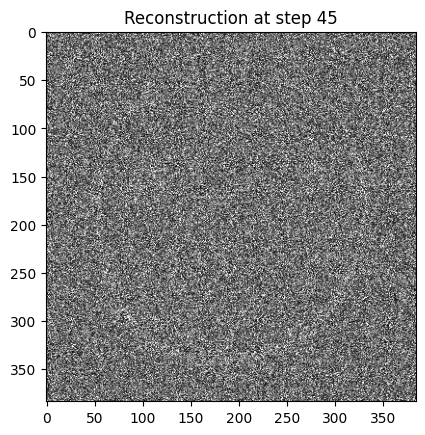

step_size: 0.4722926; error: 205.3893852; mean: 1.2470480; max: 7.7827516; :  12%|█▏        | 144/1155 [01:34<11:23,  1.48it/s]

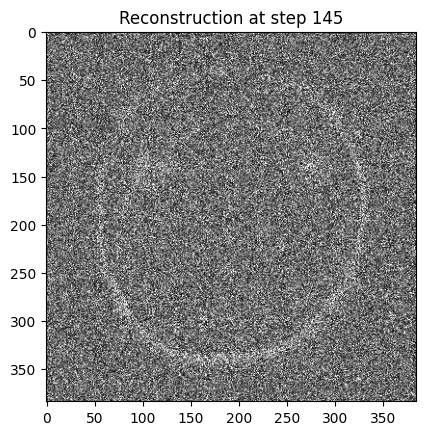

step_size: 0.1908196; error: 159.8353648; mean: 1.9564642; max: 11.2205372; :  21%|██        | 244/1155 [02:38<09:38,  1.57it/s]

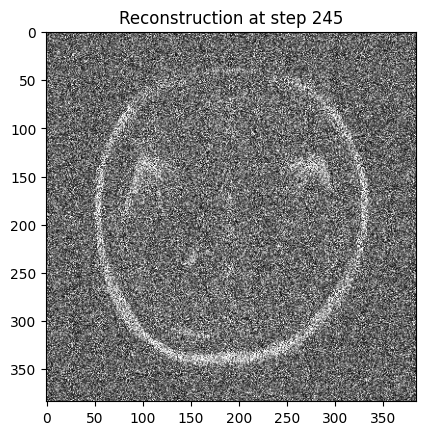

step_size: 0.0770965; error: 135.7835065; mean: 3.0749609; max: 18.4004250; :  30%|██▉       | 344/1155 [03:41<08:25,  1.60it/s]

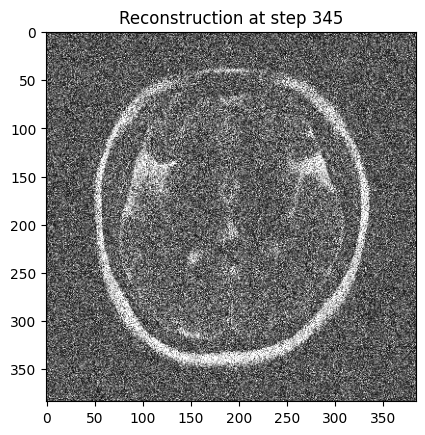

step_size: 0.0311492; error: 125.9047474; mean: 4.8212838; max: 28.4274082; :  38%|███▊      | 444/1155 [04:45<07:42,  1.54it/s]

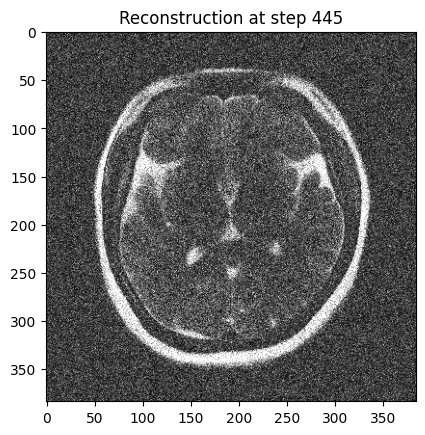

step_size: 0.0125851; error: 121.7783179; mean: 7.5336423; max: 49.1014824; :  47%|████▋     | 544/1155 [05:46<05:33,  1.83it/s]

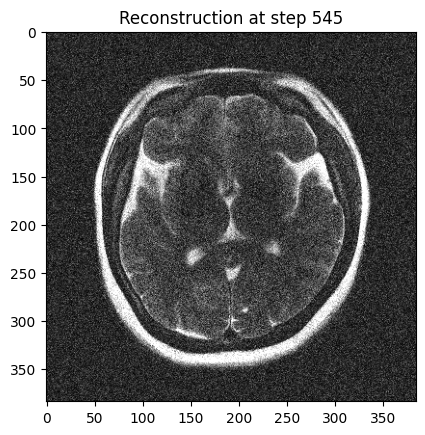

step_size: 0.0050848; error: 120.4352183; mean: 11.7450838; max: 68.9409790; :  56%|█████▌    | 644/1155 [06:40<04:25,  1.92it/s]

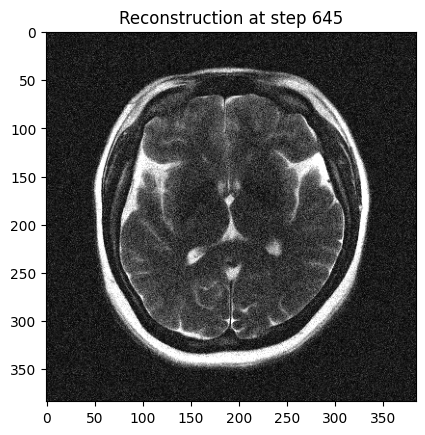

step_size: 0.0020544; error: 119.7134007; mean: 18.0616302; max: 111.0585556; :  64%|██████▍   | 744/1155 [07:52<04:59,  1.37it/s]

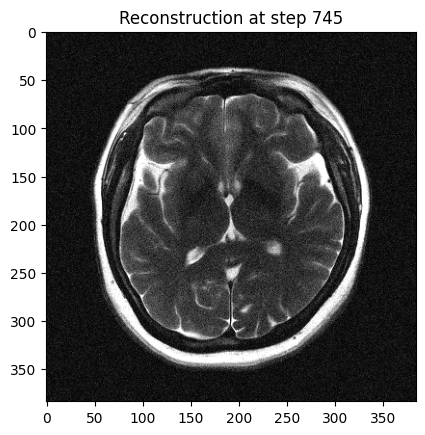

step_size: 0.0008300; error: 119.4671346; mean: 27.2648907; max: 155.8222198; :  73%|███████▎  | 844/1155 [09:03<03:34,  1.45it/s]

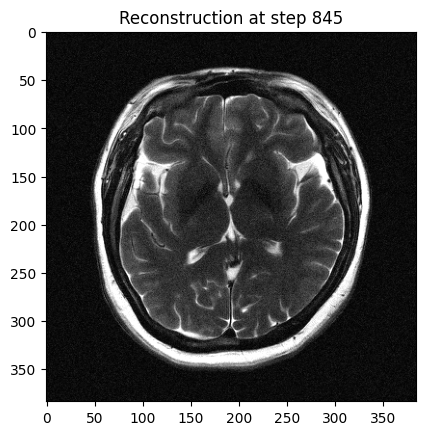

step_size: 0.0006924; error: 119.4912406; mean: 29.3234081; max: 191.5979614; :  75%|███████▍  | 864/1155 [09:18<03:08,  1.55it/s]


Automatic early stopping activated.


In [7]:
# run sampling
outputs = SMRD_optimizer.sample((ref, mvue, maps, mask))

We will visualize the final reconstruction.

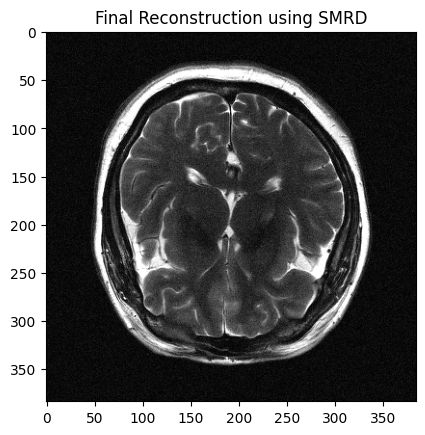

In [8]:
# visualize results
outputs[0] = outputs[0]['mvue'].permute(0, 2, 3, 1)
outputs[0] = torch.view_as_complex(outputs[0])
norm_output = torch.abs(outputs[0]).cpu().numpy()
gt = torch.abs(torch.from_numpy(sample['mvue'])).squeeze(1).cpu().numpy()
img = scale(torch.from_numpy(norm_output))
plt.figure()
plt.imshow(img.cpu().squeeze(0).numpy(), cmap='gray')
plt.title('Final Reconstruction using SMRD')
plt.show()

Compare the results with the ground truth and the zero-filled reconstruction.

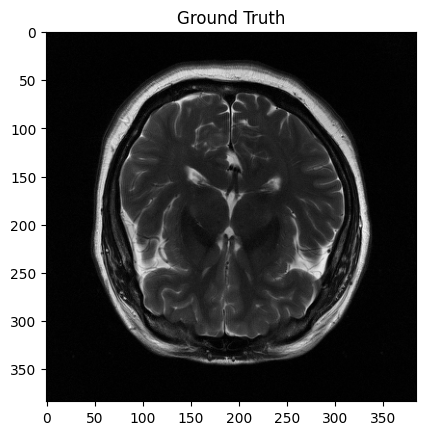

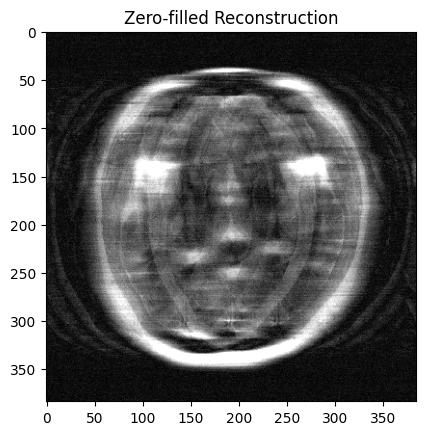

In [9]:
plt.figure()
plt.imshow(gt[0].squeeze(), cmap='gray')
plt.title('Ground Truth')
estimated_mvuevis = torch.abs(estimated_mvue)
estimated_mvuevis = scale(estimated_mvuevis)
estimated_mvue = estimated_mvuevis[batch_idx:batch_idx + 1].abs().flip(-2)
plt.figure()
plt.imshow(estimated_mvue.squeeze(0).cpu().numpy(), cmap='gray')
plt.title('Zero-filled Reconstruction')
plt.show()